In [48]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson

In [49]:
path = "~/Documents/spatial_clustering/final_project/data/"
census_df = gpd.read_file(
    path + "census_tracts/geo_export_a19e0577-c0ec-456a-8bea-703d57c3459d.shp"
)
census_df.shape

(801, 10)

In [50]:
bus_point_df = gpd.read_file(
    path + "CTA_BusStops/CTA_BusStops.shp"
)
bus_point_df.shape

(10760, 10)

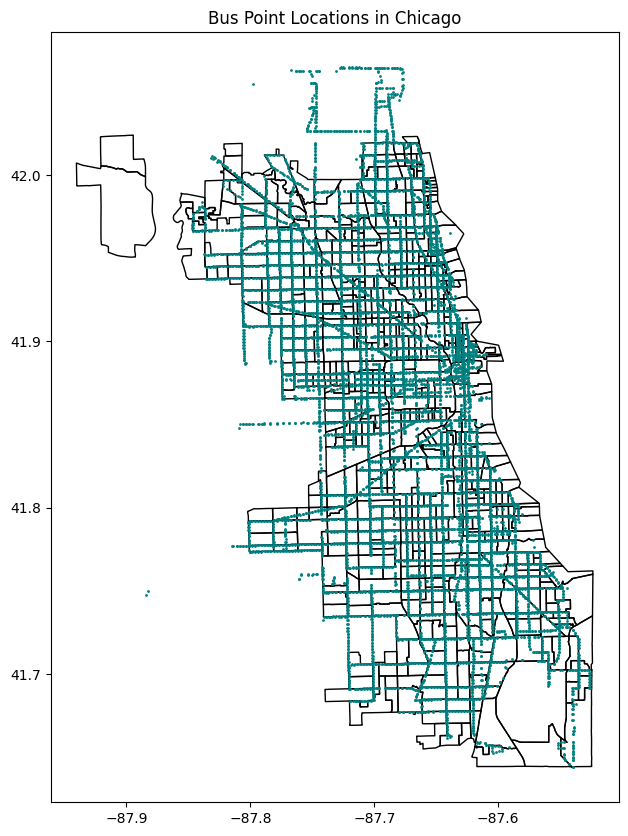

In [54]:
census_plot_df = census_df.to_crs(bus_point_df.crs)
fig, ax = plt.subplots(figsize=(10, 10))
census_plot_df.plot(ax=ax, color='none', edgecolor='black') 
bus_point_df.plot(ax=ax, markersize=1, color='teal')
plt.title('Bus Point Locations in Chicago')
plt.savefig('../figures/census_bus.png')
plt.show()

In [55]:
bus_point_df = bus_point_df.to_crs(census_df.crs)
bus_point_census = gpd.sjoin(bus_point_df, census_df, how='inner', op='intersects')


/Users/meganmoore/miniconda3/envs/transit_clustering/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [56]:
point_sum = bus_point_census.groupby('geoid10').size().reset_index(name='count')
point_sum.head(5)

,geoid10,count
0,17031010100,1
1,17031010201,3
2,17031010202,12
3,17031010300,14
4,17031010400,9


In [57]:
prob_census_df = census_df.merge(point_sum, how='left', on='geoid10').fillna(0)
prob_census_df.describe()

,commarea_n,count
count,801.000000,801.000000
mean,34.998752,12.429463
std,22.796080,8.279362
min,1.000000,0.000000
25%,16.000000,7.000000
50%,29.000000,11.000000
75%,56.000000,16.000000
max,77.000000,63.000000


In [59]:
# Area calculations
prob_census_df['areakm2'] = prob_census_df.geometry.area / 10**6

# Average Intensity
avg_intensity = prob_census_df['count'].sum() / prob_census_df['areakm2'].sum()
print("Average Intensity:",avg_intensity)

# Expected number of points in each area
prob_census_df['exppts'] = avg_intensity * prob_census_df['areakm2']
prob_census_df.head()

Average Intensity: 146343421959.47424


/var/folders/d4/vbphhpzx0_585fnvq9gjq5z00000gn/T/ipykernel_46525/2596468595.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prob_census_df['areakm2'] = prob_census_df.geometry.area / 10**6


,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,count,areakm2,exppts
0,44,44.0,031,17031842400,8424,Census Tract 8424,0,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",38.0,2.130768e-10,31.182391
1,59,59.0,031,17031840300,8403,Census Tract 8403,0,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",21.0,9.009214e-11,13.184392
2,34,34.0,031,17031841100,8411,Census Tract 8411,0,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",32.0,1.239465e-10,18.138749
3,31,31.0,031,17031841200,8412,Census Tract 8412,0,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",15.0,6.780896e-11,9.923395
4,32,32.0,031,17031839000,8390,Census Tract 8390,0,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",14.0,5.600957e-11,8.196633


In [60]:
# prob_census_df.loc[prob_census_df.loc[:, 'exppts'] > 120, 'exppts'] = prob_census_df.loc[:, 'exppts'].mean()

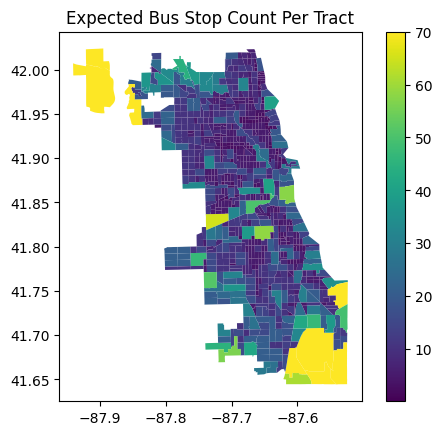

In [64]:
# prob_census_df[['exppts','geometry']].plot('exppts', legend=True)

fig, ax = plt.subplots()
prob_census_df[['exppts','geometry']].plot('exppts', ax=ax, legend=True, vmax=70)
plt.title('Expected Bus Stop Count Per Tract')
plt.savefig("../figures/expected_bus_per_tract.png")
plt.show()

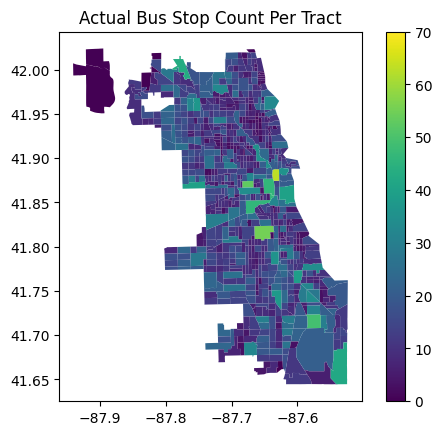

In [65]:
fig, ax = plt.subplots()
prob_census_df[['count','geometry']].plot('count', ax=ax, legend=True, vmax=70)
plt.title('Actual Bus Stop Count Per Tract')
plt.savefig("../figures/actual_bus_per_tract.png")
plt.show()

In [66]:
prob_census_df['ptprob'] = poisson.pmf(prob_census_df['count'], prob_census_df['exppts'])

conditions = [(prob_census_df['count'] > prob_census_df['exppts']) & (prob_census_df['ptprob'] < 0.05),
            (prob_census_df['count'] < prob_census_df['exppts']) & (prob_census_df['ptprob'] < 0.05)]

prob_census_df['prob_map'] = np.select(conditions,
                                 ['More than expected', 'Less than expected'], 
                                 default='Non-significant')

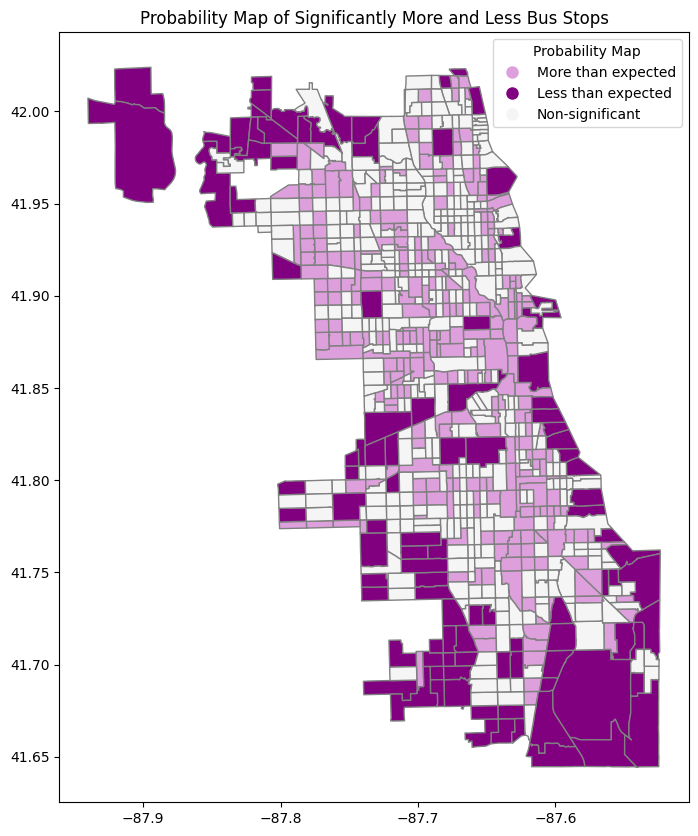

In [67]:
category_colors = {'More than expected': 'plum', 'Less than expected': 'purple', 'Non-significant': 'whitesmoke'}
fig, ax = plt.subplots(figsize=(20, 10))

for category, color in category_colors.items():
    prob_census_df[prob_census_df['prob_map'] == category].plot(ax=ax, color=color, label=category, edgecolor='grey')
    
# bus_point_df.plot(ax=ax, color='red', markersize=0.5)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in category_colors.values()]
labels = category_colors.keys()
ax.legend(handles, labels, title='Probability Map', loc='upper right')
plt.title('Probability Map of Significantly More and Less Bus Stops')
plt.savefig("../figures/probability_map_bus_point.png")
plt.show()